In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from risparser import convert_ris_to_csv

# visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

## Read files

In [2]:
# convert RIS files to CSV
raw_files = [raw_files for raw_files in os.listdir("raw") if raw_files.endswith(".ris")]
os.makedirs("csv", exist_ok=True)
for ris_file in raw_files:
    ris_fp = os.path.join("raw", ris_file)
    csv_fp = os.path.join("csv", os.path.splitext(ris_file)[0] + ".csv")
    convert_ris_to_csv(ris_fp, csv_fp)

Input file: raw/schoot-lgmm-ptsd-initial.ris
Number of articles: 6187
Export file: csv/schoot-lgmm-ptsd-initial.csv
Input file: raw/schoot-lgmm-ptsd-included-1.ris
Number of articles: 363
Export file: csv/schoot-lgmm-ptsd-included-1.csv
Input file: raw/schoot-lgmm-ptsd-included-3.ris
Number of articles: 8
Export file: csv/schoot-lgmm-ptsd-included-3.csv
Input file: raw/schoot-lgmm-ptsd-included-2.ris
Number of articles: 38
Export file: csv/schoot-lgmm-ptsd-included-2.csv


In [3]:
# full dataset
df_all = pd.read_csv("csv/schoot-lgmm-ptsd-initial.csv")
# included after abstract screening
df_abstract_screening = pd.read_csv("csv/schoot-lgmm-ptsd-included-1.csv")
# included after full text screening
df_included = pd.read_csv("csv/schoot-lgmm-ptsd-included-2.csv")
# directly included without full text screening
df_dir_included = pd.read_csv("csv/schoot-lgmm-ptsd-included-3.csv")

## Clean datasets

In [4]:
# merge datasets
df_merged = df_dir_included.append(df_included, sort=False).append(df_abstract_screening, sort=False).append(df_all, sort=False)

In [5]:
# remove duplicates (ones with missing abstracts are removed first)
df_merged = df_merged.assign(title_clean=df_merged["title"].str.replace("[^A-Za-z0-9]", "", regex=True).str.lower())
df_merged.sort_values(["title_clean", "abstract"], inplace=True)
df_merged = df_merged[(~df_merged["title_clean"].duplicated()) | (df_merged["title_clean"].isnull())].reset_index(drop=True)

In [6]:
# titles of inclusions after abstract screening
abstract_screening_title = df_abstract_screening["title"].str.replace("[^A-Za-z0-9]", "", regex=True)
# titles of inclusions after full text screening
included_title = df_included["title"].str.replace("[^A-Za-z0-9]", "", regex=True)
# titles of direct inclusions without full text screening
dir_included_title = df_dir_included["title"].str.replace("[^A-Za-z0-9]", "", regex=True)

In [7]:
# add labels and sort
label_dir_included = df_merged["title_clean"].isin(dir_included_title.str.lower())
label_included = df_merged["title_clean"].isin(included_title.str.lower())
label_abstract_screening = df_merged["title_clean"].isin(abstract_screening_title.str.lower()) | df_merged["title_clean"].isin(included_title.str.lower())
df_merged = df_merged.assign(label_dir_included=label_dir_included.astype(int), label_included=label_included.astype(int), label_abstract_screening=label_abstract_screening.astype(int))
df_merged = df_merged.sort_values(by=["label_dir_included", "label_included", "label_abstract_screening"], ascending=False).reset_index(drop=True)

In [8]:
# reset ids
df_merged["record_id"] = df_merged.index + 1

In [9]:
# impute title with secondary title if NA
df_merged.fillna({"title": df_merged["secondary_title"]}, inplace=True)

In [10]:
# fix unexpected value/mark
df_merged.loc[df_merged.year == 0, "year"] = np.nan
df_merged["authors"] = df_merged["authors"].str.replace("[\\[']", "", regex=True).str.replace("\\]", "", regex=True)
df_merged["keywords"] = df_merged["keywords"].str.replace("[\\[']", "", regex=True).str.replace("\\]", "", regex=True)

In [11]:
# retain useful columns and sort by labels
df_merged = df_merged[["record_id", "title", "abstract", "keywords", "authors", "year", "doi", "label_dir_included", "label_included", "label_abstract_screening"]]

## Export datasets

In [12]:
Path("output").mkdir(parents=True, exist_ok=True)
df_merged.to_csv("output/van_de_Schoot_2017.csv", index=False)

## Dataset statistics

In [13]:
n = len(df_merged)
n_dir_inc = df_merged["label_dir_included"].sum()
n_inc = df_merged["label_included"].sum()
n_inc_abs = df_merged["label_abstract_screening"].sum()
n_exc = n - n_inc
n_exc_abs = n - n_inc_abs
n_exc_full = n_inc_abs - n_inc

print("Number of papers with missing title:              ", df_merged["title"].isna().sum(), "\n")
print("Number of papers with missing abstract:           ", df_merged["abstract"].isna().sum(), "\n")
print("Number of papers with missing title AND abstract: ", (df_merged['title'].isna() & df_merged["abstract"].isna()).sum(), "\n")
print("Number of papers with missing title OR abstract:  ", (df_merged['title'].isna() | df_merged["abstract"].isna()).sum(), "\n\n")

print("Total number of papers:                     ", n, "\n")
print("Total number of EXCLUSIONS:                 ", n_exc, "\n")
print("Total EXCLUSIONS after abstract screening:  ", n_exc_abs, "\n")
print("Total INCLUSIONS after abstract screening:  ", n_inc_abs, "\n")
print("Total EXCLUSIONS after full text screening: ", n_exc_full, "\n")
print("Total INCLUSIONS after full text screening: ", n_inc, " (", round(100*n_inc/n, 2), "% )*\n\n")
print("*Including", n_dir_inc, "direct INCLUSIONS without full text screening \n")

Number of papers with missing title:               5 

Number of papers with missing abstract:            736 

Number of papers with missing title AND abstract:  5 

Number of papers with missing title OR abstract:   736 


Total number of papers:                      5782 

Total number of EXCLUSIONS:                  5744 

Total EXCLUSIONS after abstract screening:   5426 

Total INCLUSIONS after abstract screening:   356 

Total EXCLUSIONS after full text screening:  318 

Total INCLUSIONS after full text screening:  38  ( 0.66 % )*


*Including 8 direct INCLUSIONS without full text screening 



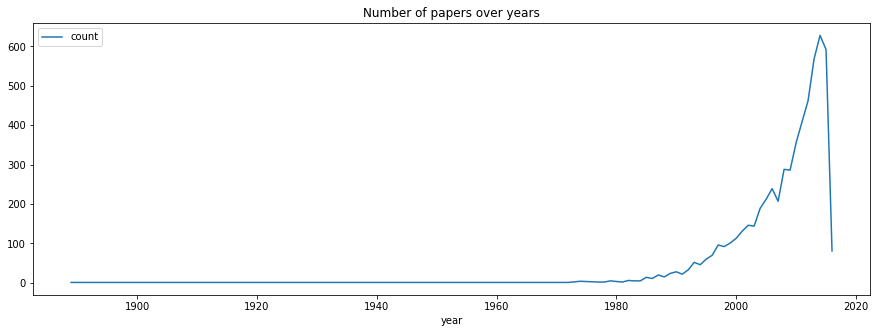

In [14]:
# number of papers over years
df_merged.groupby("year").size().reset_index(name="count").set_index("year").plot(figsize=(15,5))
plt.title("Number of papers over years")
plt.show()

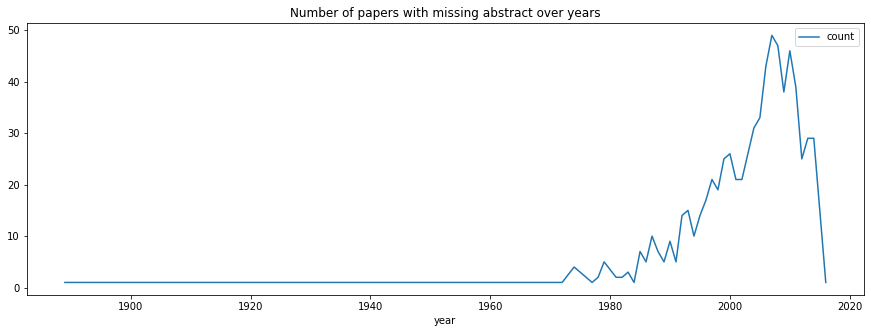

In [15]:
# missing abstract over years
df_merged["abstract"].isna().groupby(df_merged["year"]).sum().astype(int).\
reset_index(name="count").set_index("year").\
plot(figsize=(15,5))
plt.title("Number of papers with missing abstract over years")
plt.show()

There are 593249 words in the combination of all titles. 

There are 7761953 words in the combination of all abstracts. 



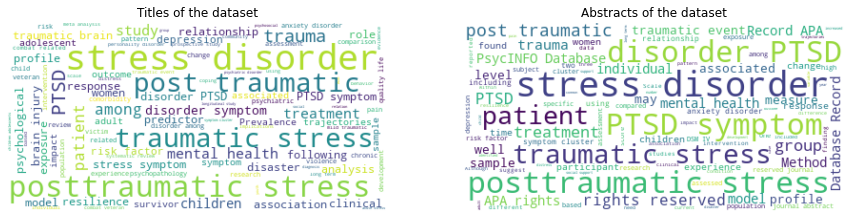

In [16]:
# word cloud for titles and abstracts
# create stopword list
stopwords = set(STOPWORDS)
stopwords.update(["effect", "effects", "result", "results", "conclusion", "conclusions"])

# create word cloud text
title_text = " ".join(word for word in df_merged.title.dropna())
abstract_text = " ".join(word for word in df_merged.abstract.dropna())
print ("There are {} words in the combination of all titles.".format(len(title_text)), "\n")
print ("There are {} words in the combination of all abstracts.".format(len(abstract_text)), "\n")

# generate word cloud images
title_wordcloud = WordCloud(stopwords=stopwords, max_words=100, background_color="white").generate(title_text)
abstract_wordcloud = WordCloud(stopwords=stopwords, max_words=100, background_color="white").generate(abstract_text)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[15, 15])
ax1.imshow(title_wordcloud, interpolation="bilinear")
ax1.set_title("Titles of the dataset")
ax1.axis("off")
ax2.imshow(abstract_wordcloud, interpolation="bilinear")
ax2.set_title("Abstracts of the dataset")
ax2.axis("off")
plt.show()